<a href="https://colab.research.google.com/github/WJ714/HRHC_mpi_bgc/blob/master/hrhc_tutorial_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[**paper here**](https://www.sciencedirect.com/science/article/pii/S0168192322004919)


##### The flowchart of the High Relative Humidity Correction approach.
<p align="center">
<img src="https://github.com/WJ714/HRHC_mpi_bgc/blob/master/HRHC.png?raw=1" alt="Getting started" />
</p>

# To begin with challenge, we need to download one site data and install required packages.

In [2]:
!git clone https://github.com/WJ714/HRHC_mpi_bgc.git

Cloning into 'HRHC_mpi_bgc'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 132 (delta 68), reused 36 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (132/132), 27.03 MiB | 17.40 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [3]:
!pip install git+https://github.com/WJ714/HRHC_mpi_bgc.git

  Cloning https://github.com/WJ714/HRHC_mpi_bgc.git to /tmp/pip-req-build-xyebd0bq
  Running command git clone --filter=blob:none --quiet https://github.com/WJ714/HRHC_mpi_bgc.git /tmp/pip-req-build-xyebd0bq
  Resolved https://github.com/WJ714/HRHC_mpi_bgc.git to commit cd8a5ca3ceae07a58afcd9f918f0de926370fdad
  Preparing metadata (setup.py) ... done
  Created wheel for hirhc: filename=hirhc-1.0.0-py3-none-any.whl size=6047 sha256=bbfe17dbbf01f8e869e8f76d1bda467726f143319b03d530bcac59b5fbcdb9b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-n6aq95tu/wheels/63/01/ee/5fc0f168c718c9acb0dc2a7b53fdb005ccc76527d42d2de2cf
Successfully built hirhc


# we go to the downloaded folder first by running:
```python
cd HRHC_mpi_bgc
```

In [4]:
cd HRHC_mpi_bgc

/content/HRHC_mpi_bgc


- then we can import these packages in Jupyter notebook:
    - **Note** that the HRHC_fnuction is a file containing all HRHC correction functions.

In [5]:
## import libraries
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

## import the local librarie
from hirhc import hirhc_function as hrhc

- we load a test dataset (FR-Pue) at the half-hourly scale from the FLUXNET 2015 dataset. The original downloaded data is a .csv file, which we first read with pandas (df) and then convert to an xarray dataset (ds0).

In [6]:
df = pd.read_csv('FLX_FR-Pue_FLUXNET2015_FULLSET_HH_2007-2009_2-4.csv',parse_dates=['TIMESTAMP_START'])
ds0 = df.rename(columns={'TIMESTAMP_START':'time'}).set_index('time').to_xarray()

- we select all nesssesary variables:
    ```python
    - Key variables: [TA, RH, LE, G, H, NETRAD]
    - QC flags: [NEE_CUT_50_QC, LE_F_MDS_QC, H_F_MDS_QC, G_F_MDS_QC]
    ```
    - Here we keep NEE_CUT_50_QC as well to gap fill the NaN values in other QC flags.

In [7]:
ds = ds0[['TA_F_MDS', 'RH', 'LE_F_MDS', 'H_F_MDS', 'G_F_MDS', 'NETRAD', 'NEE_CUT_50_QC','LE_F_MDS_QC', 'H_F_MDS_QC', 'G_F_MDS_QC']]
ds['NETRAD_QC'] = ds['NETRAD']*0
ds = ds.where(ds!=-9999, np.nan)
ds = ds.rename_vars({
    'TA_F_MDS':'TA',
    'LE_F_MDS':'LE',
    'H_F_MDS':'H',
    'G_F_MDS':'G',
    'NEE_CUT_50_QC':'NEE_QC',
    'LE_F_MDS_QC':'LE_QC',
    'H_F_MDS_QC':'H_QC',
    'G_F_MDS_QC':'G_QC'
    })
ds.attrs['agg_code'] = 'HH'

- we can check out the dataset by calling 'ds':

In [8]:
ds

<xarray.Dataset> Size: 5MB
Dimensions:    (time: 52608)
Coordinates:
  * time       (time) datetime64[ns] 421kB 2007-01-01 ... 2009-12-31T23:30:00
Data variables:
    TA         (time) float64 421kB 8.73 8.6 8.59 8.34 ... 8.42 8.23 8.17 8.39
    RH         (time) float64 421kB 99.9 100.0 100.0 100.0 ... 100.0 100.0 100.0
    LE         (time) float64 421kB -0.8827 7.307 10.86 ... 5.046 -0.4937
    H          (time) float64 421kB -53.82 -53.44 13.73 ... -17.72 -8.081 -6.02
    G          (time) float64 421kB 0.3286 0.5121 0.585 ... -1.289 -1.278 -1.467
    NETRAD     (time) float64 421kB -0.134 -0.089 -1.836 ... -38.27 -16.08
    NEE_QC     (time) float64 421kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    LE_QC      (time) float64 421kB 0.0 1.0 0.0 0.0 0.0 ... 0.0 0.0 1.0 0.0 0.0
    H_QC       (time) float64 421kB 1.0 1.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    G_QC       (time) float64 421kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    NETRAD_QC  (time) float64 421kB -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0 -0.0
Attributes:
    agg_code:  HH

##### 2nd, We need to convert LE (W m-2) to ET (kg m-2 s-1 / mm s-1) based on the formula from:
        - Stull, B., 1988: An Introduction to Boundary Layer Meteorology (p.641) Kluwer Academic Publishers, Dordrecht, Netherlands
        - Foken, T, 2008: Micrometeorology. Springer, Berlin, Germany.

In [9]:
ds['ET'] = hrhc.LE_to_ET(ds.LE, ds.TA, 24) # the function is provided in our package.

##### 3rd, we can have a look at the LER variation along Relative Humidity (RH) at the hourly scale (Figure 1).
$$LER=\frac{LE}{NETRAD-H-G}$$
- We will only work with the observed data (QC==0), and filter out negative LE and negative values of (NETRAD - H - G)

Text(0.5, 1.0, '$Figure\\ 1\\ LER\\ (original)\\ vs.\\ RH$')

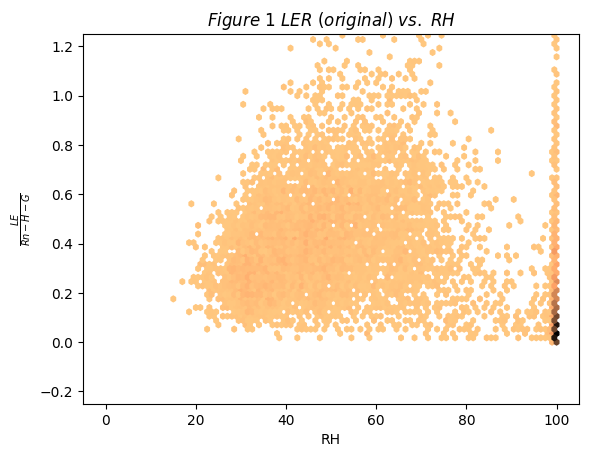

In [10]:
QC_mask = (ds['NETRAD_QC'] ==0) & (ds['H_QC'] ==0) & (ds['LE_QC'] ==0) & (ds['G_QC'] ==0) & (ds['LE'] >=0) & ((ds['NETRAD'] - ds['H'] - ds['G'])>=0) # maks sure all data are measured and without gapfilling

plt.figure()
plt.hexbin(ds['RH'][QC_mask], (ds['LE'] / (ds['NETRAD'] - ds['H'] - ds['G']))[QC_mask], extent = [0,100,0,2],  cmap=plt.cm.copper_r, gridsize=100, mincnt=3)
plt.ylim(-0.25,1.25)
plt.xlabel('RH')
plt.ylabel(r'$\frac{LE}{Rn-H-G}$')
plt.title(r'$Figure\ 1\ LER\ (original)\ vs.\ RH$')

##### 4th, Start to apply the high RH error correction (HRHC).
- as the whole correction function is a class object, so it is easilly applied by the following steps, then the correction factor, corrected ET will be added to the dataset (ds).

In [11]:
apply_hrhc = hrhc.HRHC_Correcter(ds)

- create a base mask which is the combination of all the QC mask and 'outlier' mask.

In [12]:
apply_hrhc.basemask()

- train the machine learning model (xgboost), and predict the decreasing trend of LER

In [13]:
apply_hrhc.xgb_pred()

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:771: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [22]:
ds

<xarray.Dataset> Size: 8MB
Dimensions:        (time: 52608)
Coordinates:
  * time           (time) datetime64[ns] 421kB 2007-01-01 ... 2009-12-31T23:3...
Data variables: (12/22)
    TA             (time) float64 421kB 8.73 8.6 8.59 8.34 ... 8.23 8.17 8.39
    RH             (time) float64 421kB 99.9 100.0 100.0 ... 100.0 100.0 100.0
    LE             (time) float64 421kB -0.8827 7.307 10.86 ... 5.046 -0.4937
    H              (time) float64 421kB -53.82 -53.44 13.73 ... -8.081 -6.02
    G              (time) float64 421kB 0.3286 0.5121 0.585 ... -1.278 -1.467
    NETRAD         (time) float64 421kB -0.134 -0.089 -1.836 ... -38.27 -16.08
    ...             ...
    MEF            float64 8B 0.1225
    LER_pred_plot  (time) float64 421kB nan nan nan nan nan ... nan nan nan nan
    imb_ref        float64 8B 0.4406
    Fcor           (time) float64 421kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    LEcor          (time) float64 421kB -0.8827 7.307 10.86 ... 5.046 -0.4937
    ETcor          (time) float64 421kB -0.0006406 0.005302 ... -0.0003581
Attributes:
    agg_code:  HH

- We can look at the predicted trend of LE (Figure 2).

Text(0.5, 1.0, '$Figure\\ 2\\ LER\\ (original\\ and\\ predicted)\\ vs.\\ RH$')

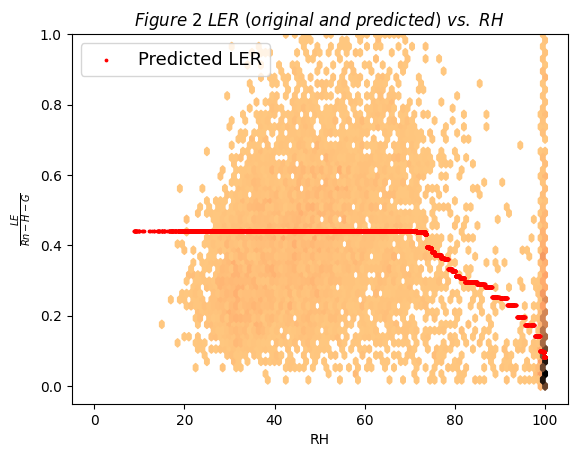

In [14]:
plt.figure()
plt.hexbin(ds['RH'][QC_mask], (ds['LE'] / (ds['NETRAD'] - ds['H'] - ds['G']))[QC_mask], extent = [0,100,0,2], cmap=plt.cm.copper_r, gridsize=100, mincnt=3)
plt.scatter(ds.RH, ds.LER_pred, c='r', s=3, label='Predicted LER')
plt.ylim(-0.05,1)
plt.xlabel('RH')
plt.ylabel(r'$\frac{LE}{Rn-H-G}$')
plt.legend(fontsize=13, loc='upper left')
plt.title(r'$Figure\ 2\ LER\ (original\ and\ predicted)\ vs.\ RH$')

- then we can compute correction factors and corrected LER, and thereby computing corrected LE.

In [15]:
apply_hrhc.LE_corr()

- We can look at the distribution of correction factor along RH (Figure 3).

Text(0.5, 1.0, '$Figure\\ 3\\ Correction\\ Factor\\ vs.\\ RH$')

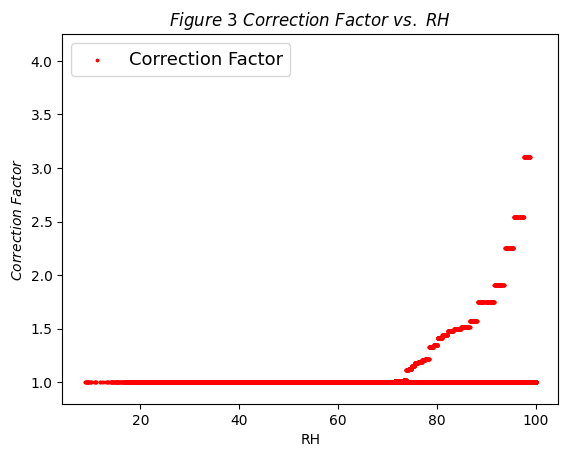

In [16]:
plt.figure()
plt.scatter(ds.RH, ds.Fcor, c='r', s=3, label='Correction Factor')
plt.ylim(0.8,4.25)
plt.xlabel('RH')
plt.ylabel(r'$Correction\ Factor$')
plt.legend(fontsize=13, loc='upper left')
plt.title(r'$Figure\ 3\ Correction\ Factor\ vs.\ RH$')

- We can also look at the comparisopn of corrected LE and original LE (Figure 4).

Text(0.5, 1.0, '$Figure\\ 4\\ Corrected\\ LE\\ vs.\\ Original\\ LE$')

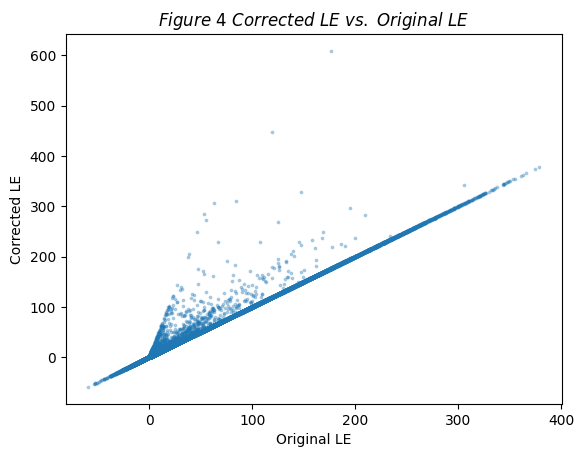

In [17]:
plt.figure()
plt.scatter(ds.LE, ds.LEcor, s=3, alpha=0.3)
plt.xlabel('Original LE')
plt.ylabel('Corrected LE')
plt.title(r'$Figure\ 4\ Corrected\ LE\ vs.\ Original\ LE$')

- We can also look at the abslute changes of LE (Figure 5).

Text(0.5, 1.0, '$Figure\\ 5\\ Changes\\ in\\ LE\\ vs.\\ RH$')

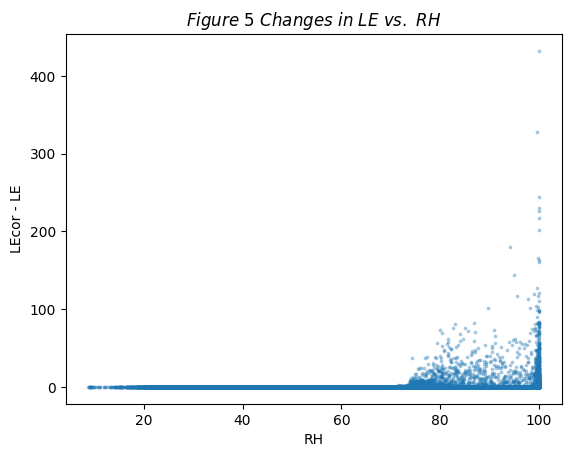

In [18]:
plt.figure()
plt.scatter(ds.RH, ds.LEcor - ds.LE, s=3,alpha=0.3)
plt.xlabel('RH')
plt.ylabel('LEcor - LE')
plt.title(r'$Figure\ 5\ Changes\ in\ LE\ vs.\ RH$')

In [19]:
# plt.figure()
# (ds.LEcor/ds.LE).sel(time='2007-10').plot(label='change in LE')
# (ds.RH/100).sel(time='2007-10').plot(label='Relative Humidity')
# plt.legend(fontsize=13, loc='center left')
# plt.ylabel('LEcor - LE [W m-2], or, RH [~]')
# # plt.title(r'$Figure\ 5\ Changes\ in\ LE\ vs.\ RH$')

##### Done!
- then we can have a look at the dataset, and the corrected LE is labelled "LE_cor"

In [20]:
ds

<xarray.Dataset> Size: 8MB
Dimensions:        (time: 52608)
Coordinates:
  * time           (time) datetime64[ns] 421kB 2007-01-01 ... 2009-12-31T23:3...
Data variables: (12/22)
    TA             (time) float64 421kB 8.73 8.6 8.59 8.34 ... 8.23 8.17 8.39
    RH             (time) float64 421kB 99.9 100.0 100.0 ... 100.0 100.0 100.0
    LE             (time) float64 421kB -0.8827 7.307 10.86 ... 5.046 -0.4937
    H              (time) float64 421kB -53.82 -53.44 13.73 ... -8.081 -6.02
    G              (time) float64 421kB 0.3286 0.5121 0.585 ... -1.278 -1.467
    NETRAD         (time) float64 421kB -0.134 -0.089 -1.836 ... -38.27 -16.08
    ...             ...
    MEF            float64 8B 0.1225
    LER_pred_plot  (time) float64 421kB nan nan nan nan nan ... nan nan nan nan
    imb_ref        float64 8B 0.4406
    Fcor           (time) float64 421kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    LEcor          (time) float64 421kB -0.8827 7.307 10.86 ... 5.046 -0.4937
    ETcor          (time) float64 421kB -0.0006406 0.005302 ... -0.0003581
Attributes:
    agg_code:  HH